# Making Predictions

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

from statsmodels.tsa.ar_model import AutoReg
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

##  Getting all the datasets

In [176]:
# importing the prediction data
df_pred = pd.read_csv('../clean_data/predictions.csv')

# lets rename columns for easy use
df_pred.rename(columns={"Unnamed: 0": "date" , "7dayrollingavg_newlyconfirmed":"7D_roll_pred", 'County':'county'},inplace = True)

# lets reset the index to county
df_pred.set_index('county', inplace= True)

# import data wise california vaccine allocation

df_vacc_alloc = pd.read_csv('../clean_data/vaccine_population.csv')
df_vacc_alloc = df_vacc_alloc[df_vacc_alloc['jurisdiction'] == 'California']
df_vacc_alloc.drop(columns=['2019_population','hhs_region','total_first_allocation' ], inplace = True)

# importing vaccination adminstration  data
df_vacc_admin = pd.read_csv('../clean_data/scrapped_ca_vaccine.csv')

# importing county population data
df_county_pop = pd.read_csv('../clean_data/cases_with_mask_use.csv')

# get county and population information only
df_county_pop = pd.DataFrame(df_county_pop.groupby(by = 'county')['population'].max())


##  EDA on county population

In [226]:
df_county_pop.head()

,population,ratio_county_pop,joinkey
county,,,
Alameda,1671329,0.042299,0
Alpine,1129,0.000029,0
Amador,39752,0.001006,0
Butte,219186,0.005547,0
Calaveras,45905,0.001162,0


In [229]:
# Lets create a column that gives the county population ratio to California pop
# of county population to total california population. We will use this for dosage distribution
df_county_pop['ratio_county_pop'] = (df_county_pop['population']/ df_county_pop['population'].sum())
df_county_pop.reset_index(inplace= True)

## EDA on prediction data

In [178]:
# lets look at the data
df_pred.head()
# '2021-02-14'

,date,7D_roll_pred
county,,
Alameda,2020-09-27,5.572982
Alameda,2020-09-28,5.402031
Alameda,2020-09-29,5.419126
Alameda,2020-09-30,4.726777
Alameda,2020-10-01,4.367782


## EDA on vaccination Adminstration data

In [253]:
df_vacc_admin

,state,date,total_doses_distributed,total_doses_administered,doses_dist_7roll,doses_admin_7roll,joinkey
0,California,2021-01-16,3548575,1072959,830925,560916,0
1,California,2021-01-17,3548575,1072959,1166050,730720,0
2,California,2021-01-18,3548575,1072959,1357950,935261,0
3,California,2021-01-19,3548575,1072959,1357950,1126949,0
4,California,2021-01-20,3548575,1072959,1357950,1257674,0
5,California,2021-01-21,4169450,1532329,849820,993356,0
6,California,2021-01-22,4379500,1633875,749364,1102283,0
7,California,2021-01-23,4714625,1803679,520769,1159592,0
8,California,2021-01-24,4906525,2008220,432421,1200119,0
9,California,2021-01-25,4906525,2199908,533079,1272874,0


In [179]:
# lets look at the data
df_vacc_admin = df_vacc_admin[df_vacc_admin['state']=='California'][['state' , 'date' ,'total_doses_distributed','total_doses_administered']]
df_vacc_admin["date"]= pd.to_datetime(df_vacc_admin["date"]) 

#### Two steps to be added for this
#### Step 1: need to expand the data till 2021-02-14
#### Step 2: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.
#### Step 3: need to split up the data for each county by date.



### Step 1: need to expand the data till 2021-02-14

In [180]:
# function to get the next values based on AutoReg Time Series
def autoreg_dist(df):
    data = df['total_doses_distributed']
    model = AutoReg(data, lags=1)
    model_fit = model.fit()
    y = model_fit.predict(len(data), len(data))
    return round(y)

In [182]:
# function to get the next values based on AutoReg Time Series
def autoreg_admin(df):
    data = df['total_doses_administered']
    model = AutoReg(data, lags=1)
    model_fit = model.fit()
    y = model_fit.predict(len(data), len(data))
    return round(y)

In [183]:
max_dt = df_vacc_admin['date'].max()
for i in range(1,29):
    lst_dict = []
    lst_dict.append(    {   'state': 'California',
                            'date': max_dt,
                            'total_doses_distributed' : int(autoreg_dist(df_vacc_admin)),
                            'total_doses_administered' :int(autoreg_admin(df_vacc_admin))
                           })
    df_vacc_admin = df_vacc_admin.append(pd.DataFrame(lst_dict), ignore_index=True )
    max_dt = max_dt + dt.timedelta(days=1)




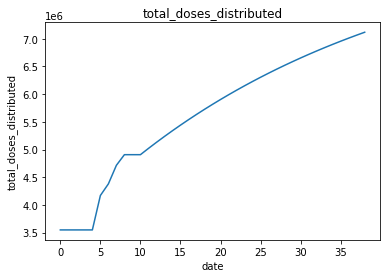

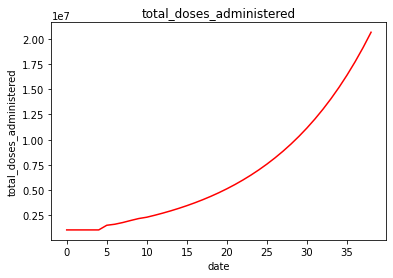

In [184]:


# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['total_doses_distributed'])
plt.title('total_doses_distributed')
plt.ylabel('total_doses_distributed');
plt.xlabel('date');
plt.show()

# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['total_doses_administered'] , 'r')
plt.title('total_doses_administered')
plt.ylabel('total_doses_administered');
plt.xlabel('date');
plt.show()



### Step 2: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.

In [207]:
# lets create new column that is the cumulative 7 days for doses adminstered and doses distributed

df_vacc_admin['doses_dist_7roll'] = 0
df_vacc_admin['doses_admin_7roll'] = 0
for i in range(0,32):
    df_vacc_admin['doses_dist_7roll'][i]= df_vacc_admin['total_doses_distributed'][i+6]- df_vacc_admin['total_doses_distributed'][i]
    df_vacc_admin['doses_admin_7roll'][i]= df_vacc_admin['total_doses_administered'][i+6]- df_vacc_admin['total_doses_administered'][i]
    

### Step 3: Need to split the data by county

In [230]:
df_county_pop.head()

,county,population,ratio_county_pop,joinkey
0,Alameda,1671329,0.042299,0
1,Alpine,1129,0.000029,0
2,Amador,39752,0.001006,0
3,Butte,219186,0.005547,0
4,Calaveras,45905,0.001162,0


In [224]:
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered,doses_dist_7roll,doses_admin_7roll,joinkey
0,California,2021-01-16,3548575,1072959,830925,560916,0
1,California,2021-01-17,3548575,1072959,1166050,730720,0
2,California,2021-01-18,3548575,1072959,1357950,935261,0
3,California,2021-01-19,3548575,1072959,1357950,1126949,0
4,California,2021-01-20,3548575,1072959,1357950,1257674,0


In [251]:
# lets do a cross join and merge the data sets for county and county population ratio. 
# this will help us to divide the doses admininstered and doses distributed 7 days cumulative by county

# since we have to do a cross join on two data frames that donot have a Key, lets create a key that is same.
df_county_pop['joinkey'] = 0
df_vacc_admin['joinkey'] = 0

# lets merge the vaccine and county population data together
df_county_vacc_dist_admin_7Droll = pd.merge(df_vacc_admin, df_county_pop, on="joinkey" , how="outer")

# selecting only the columns we need
df_county_vacc_dist_admin_7Droll = df_county_vacc_dist_admin_7Droll[['county' ,'date','doses_dist_7roll','doses_admin_7roll', 'ratio_county_pop']]

# rounding the county distribution and adminstration numbers
df_county_vacc_dist_admin_7Droll['doses_dist_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_dist_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])
df_county_vacc_dist_admin_7Droll['doses_admin_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_admin_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])

# selecting only the columns we needed
df_county_vacc_dist_admin_7Droll=df_county_vacc_dist_admin_7Droll[['county', 'date', 'doses_dist_7roll_county' , 'doses_admin_7roll_county' ]]

In [252]:
# final data set for Vaccine Adminstraion and Distribution by County and Date
df_county_vacc_dist_admin_7Droll

,county,date,doses_dist_7roll_county,doses_admin_7roll_county
0,Alameda,2021-01-16,35147.0,23726.0
1,Alpine,2021-01-16,24.0,16.0
2,Amador,2021-01-16,836.0,564.0
3,Butte,2021-01-16,4609.0,3112.0
4,Calaveras,2021-01-16,965.0,652.0
...,...,...,...,...
2257,Tulare,2021-02-22,0.0,0.0
2258,Tuolumne,2021-02-22,0.0,0.0
2259,Ventura,2021-02-22,0.0,0.0
2260,Yolo,2021-02-22,0.0,0.0


### Merge data sets together

#### create a dataframe that has County, Date, Prediction, County population, vaccine allocation

In [268]:
# lets add population to predictions 
df_county_vacc_pred_7Droll  =  pd.merge(df_pred ,df_county_pop, on ='county' , how = 'left' )

# since the 7 day rolling average was based off 100K , we need to calculate actual number of 7 day new patients

df_county_vacc_pred_7Droll['7D_roll_pred_tot'] = np.round((df_county_vacc_pred_7Droll['7D_roll_pred'] * df_county_vacc_pred_7Droll['population'])/ 100_000)

# lets look at merged data
df_county_vacc_pred_7Droll = df_county_vacc_pred_7Droll[['county', 'date' ,'7D_roll_pred_tot' ]]

### Append the 'county to population ratio' to merged data set.

In [276]:
df_county_vacc_pred_7Droll["date"]= pd.to_datetime(df_county_vacc_pred_7Droll["date"]) 

In [279]:
df_county_resource = pd.merge(df_county_vacc_pred_7Droll, df_county_vacc_dist_admin_7Droll, on=['county' , 'date'], how="inner")

In [288]:
df_county_resource

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county,delta
0,Alameda,2021-01-16,923.0,35147.0,23726.0,-10498.0
1,Alameda,2021-01-17,895.0,49323.0,30909.0,-17519.0
2,Alameda,2021-01-18,856.0,57440.0,39561.0,-17023.0
3,Alameda,2021-01-19,827.0,57440.0,47669.0,-8944.0
4,Alameda,2021-01-20,745.0,57440.0,53198.0,-3497.0
...,...,...,...,...,...,...
1731,Yuba,2021-02-10,48.0,798.0,9602.0,8852.0
1732,Yuba,2021-02-11,48.0,776.0,10361.0,9633.0
1733,Yuba,2021-02-12,48.0,754.0,11181.0,10475.0
1734,Yuba,2021-02-13,48.0,733.0,12064.0,11379.0


In [222]:
# use the ratio_county_pop to divide the dosage across county. Create a new column

#final_2['dosage_allocated_01_25'] = round(final_2['ratio_county_pop'] * 485800)

In [287]:
df_county_resource['delta'] = df_county_resource['7D_roll_pred_tot'] - ( df_county_resource['doses_dist_7roll_county']- df_county_resource['doses_admin_7roll_county'])

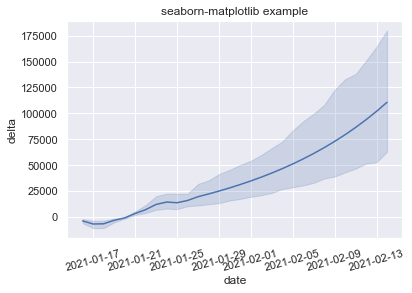

In [292]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.lineplot(x="date", y="delta", data=df_county_resource)
plt.xticks(rotation=15)
plt.title('seaborn-matplotlib example')
plt.show()

In [293]:
df_county_resource

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county,delta
0,Alameda,2021-01-16,923.0,35147.0,23726.0,-10498.0
1,Alameda,2021-01-17,895.0,49323.0,30909.0,-17519.0
2,Alameda,2021-01-18,856.0,57440.0,39561.0,-17023.0
3,Alameda,2021-01-19,827.0,57440.0,47669.0,-8944.0
4,Alameda,2021-01-20,745.0,57440.0,53198.0,-3497.0
...,...,...,...,...,...,...
1731,Yuba,2021-02-10,48.0,798.0,9602.0,8852.0
1732,Yuba,2021-02-11,48.0,776.0,10361.0,9633.0
1733,Yuba,2021-02-12,48.0,754.0,11181.0,10475.0
1734,Yuba,2021-02-13,48.0,733.0,12064.0,11379.0
